# Metadata processing
A notebook to process the metadata of the Bern cohort WSIs

## Import libraries and load data

In [50]:
import Abed_utils

import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.preprocessing import LabelEncoder

In [51]:
df = pd.read_pickle('./metadata/bern_data.pkl')
df.head()

,patient_id,gender,age,diagnosis,location_specific,location,pt,pt_group,pn,pn_group,...,tsr_path,tsr_cls_path,tsr_q25,tsr_q50,tsr_q75,tsr_mean,tsr_est_q25,tsr_est_q50,tsr_est_q75,tsr_est_mean
0,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.936087,0.976751,0.990994,0.955028,0.824026,0.876453,0.924482,0.872773
1,3,female,82.991781,adenocarcinoma,recto,rectum,pt2,pt012,pn0,pn0,...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,/mnt/data/dataset/bern_cohort_clean/3/output/s...,0.940220,0.971893,0.986070,0.930820,0.771250,0.823717,0.877430,0.820560
4,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.022578,0.054593,0.540306,0.279577,0.394779,0.487238,0.608896,0.509430
5,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.063587,0.150189,0.607203,0.332216,0.457595,0.509831,0.598535,0.512643
6,6,female,87.367123,adenocarcinoma,descending,left,pt3,pt34,pn1,pn12,...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,/mnt/data/dataset/bern_cohort_clean/6/output/s...,0.017364,0.042972,0.115521,0.130877,0.419876,0.474648,0.515490,0.466747


In [52]:
# Add tsr
pred_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'predictions_KNN')
calculated_files = [x.split('_seg')[0] for x in os.listdir(pred_path)]

print(len(set(calculated_files) - set(df.slide_filename)))
print(len(set(df.slide_filename) - set(calculated_files)))

100
278


In [53]:
def calculate_tsr(filename, accepted_files=calculated_files, pred_path=pred_path, default_value=np.nan):
    if filename in accepted_files:
        d = np.load(os.path.join(pred_path, f'{filename}_seg_dino_imagenet_100ep_KNN.npy'), allow_pickle=True).item()
        preds = d['classification']
        lbls = d['classification_labels']
        T = (preds == lbls.index('TUM')).sum()
        S = (preds == lbls.index('STR')).sum()
        return T/(T+S)
    else:
        return default_value

df['tsr'] = df.slide_filename.map(calculate_tsr)
df['tsr_disc'] = np.round(np.floor(df.tsr*10)/10, decimals=1)
df.dropna(subset=['tsr', 'os', 'dfs'],inplace=True)
df[['slide_filename', 'tsr', 'tsr_disc']].head()
# for wsi in glob(os.path.join(pred_path, '*.npy')):
#     print(np.load(wsi, allow_pickle=True).item())
#     print(os.path.basename(wsi).split('_seg')[0])
#     if os.path.basename(wsi).split('_seg')[0] in df['slide_filename']:
#         d = np.load(wsi, allow_pickle=True).item()
#         preds = d['classification']
#         lbls = d['classification_labels']
#         tsr = preds[preds == lbls.index('TUM')].sum()/preds[preds == lbls.index('STR')].sum()
#         idx = df['slide_filename'].in



,slide_filename,tsr,tsr_disc
0,003b_B2010.14359_I-D_HE.mrxs,0.760542,0.7
1,003c_B2010.14359_I-E_HE.mrxs,0.701752,0.7
4,006b_B2008.17770_I-E_HE.mrxs,0.209621,0.2
5,006c_B2008.17770_I-K_HE.mrxs,0.272062,0.2
6,006d_B2008.17770_I-G_HE.mrxs,0.102042,0.1


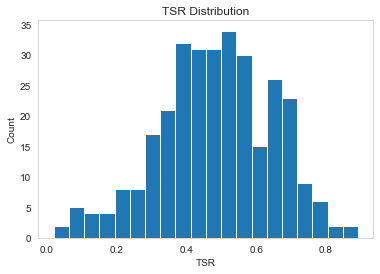

In [54]:
df.tsr.hist(bins=20)
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.grid(False)
plt.show()

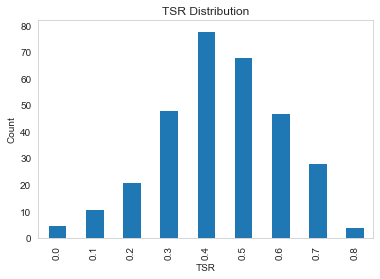

In [55]:
df.tsr_disc.value_counts().sort_index().plot.bar()
# plt.xticks(sorted(df.tsr_disc.unique()))
plt.title('TSR Distribution')
plt.xlabel('TSR')
plt.ylabel('Count')
plt.grid(False)
plt.show()

High    147
Low     163
Name: tsr_high, dtype: int64


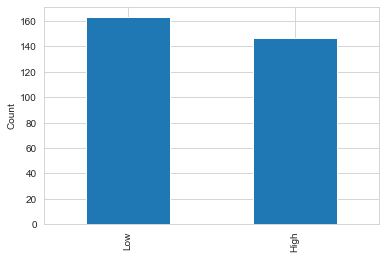

In [56]:
df['tsr_high'] = (df.tsr_disc >= 0.5).map({False:'Low', True:'High'})
print(df.tsr_high.value_counts().sort_index())
df.tsr_high.value_counts().plot.bar()
# plt.xticks([0,1],['High', 'Low'])
plt.ylabel('Count')
plt.show()

In [57]:
feature_cols = ['pm', 'pn', 'pt', 'tnm', 'tbc', 'tsr']
# feature_cols = ['pn_group']
target_cols = ['os', 'os_event']

data = df[feature_cols + target_cols].dropna()
encoders = {}
for col in data:
    if isinstance(data[col].dtype, pd.CategoricalDtype):
        encoders[col] = LabelEncoder().fit(data[col])
        data[col] = encoders[col].transform(data[col])

model = CoxPHFitter()
model.fit(data, duration_col=target_cols[0], event_col=target_cols[1], show_progress=True)

model.print_summary()

Iteration 1: norm_delta = 0.72423, step_size = 0.9000, log_lik = -412.07622, newton_decrement = 11.37291, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.11036, step_size = 0.9000, log_lik = -402.15823, newton_decrement = 0.12713, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00964, step_size = 0.9000, log_lik = -402.03266, newton_decrement = 0.00121, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -402.03146, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 240 total observations, 156 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
      baseline estimation = breslow
   number of observations = 240
number of events observed = 84
   partial log-likelihood = -402.03
         time fit was run = 2022-05-18 13:31:41 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
pm         -0.54       0.59       0.52            -1.55             0.48                 0.21                 1.61
pn          0.68       1.97       0.21             0.26             1.09                 1.29                 2.99
pt          0.11       1.12       0.22            -0.31             0.54                 0.73                 1.72
tnm        -0.10       0.91       0.24            -0.56             0.37                 0.57                 1.45
tbc        -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
tsr         0.08       1.09       0.68            -1.25             1.41                 0.29                 4.11

            cmp to     z      p   -log2(p)
covariate                                 
pm            0.00 -1.04   0.30       1.74
pn            0.00  3.17 <0.005       9.36
pt            0.00  0.52   0.60       0.74
tnm           0.00 -0.40   0.69       0.54
tbc           0.00 -0.87   0.39       1.37
tsr           0.00  0.12   0.90       0.15
---
Concordance = 0.62
Partial AIC = 816.06
log-likelihood ratio test = 20.09 on 6 df
-log2(p) of ll-ratio test = 8.55

In [58]:
print(model.summary)

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
pm        -0.535866   0.585163  0.517277       -1.549710        0.477979   
pn         0.676238   1.966466  0.213263        0.258251        1.094226   
pt         0.114371   1.121168  0.218492       -0.313866        0.542609   
tnm       -0.096290   0.908201  0.238565       -0.563868        0.371288   
tbc       -0.003245   0.996760  0.003741       -0.010578        0.004087   
tsr        0.082344   1.085829  0.678668       -1.247821        1.412509   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
pm                    0.212310             1.612811     0.0 -1.035935   
pn                    1.294663             2.986869     0.0  3.170914   
pt                    0.730617             1.720489     0.0  0.523456   
tnm                   0.56

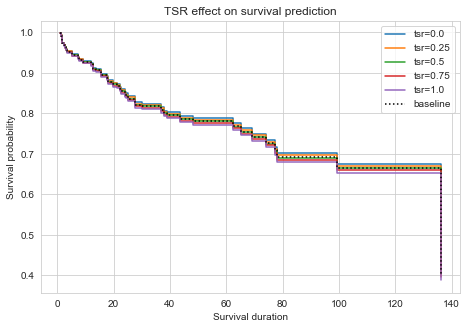

In [59]:
model.plot_partial_effects_on_outcome(['tsr'], np.linspace(0,1,5), figsize=(7.5,5))
plt.title('TSR effect on survival prediction')
plt.xlabel('Survival duration')
plt.ylabel('Survival probability')
plt.show()

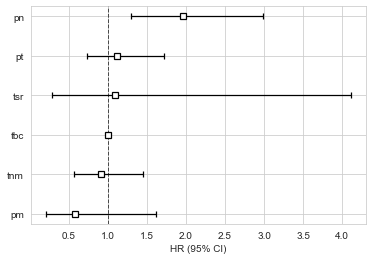

In [60]:
model.plot(hazard_ratios=True)
plt.show()

In [61]:
model.check_assumptions(data, p_value_threshold=5e-2)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\Users\Zace VR\anaconda3\envs\fresh\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 240 total observations, 156 right-censored observations>
         test_name = proportional_hazard_test

---
          test_statistic    p  -log2(p)
pm  km              0.78 0.38      1.40
    rank            1.46 0.23      2.14
pn  km              0.03 0.86      0.22
    rank            0.00 1.00      0.00
pt  km              1.82 0.18      2.49
    rank            3.63 0.06      4.14
tbc km              2.66 0.10      3.28
    rank            4.98 0.03      5.28
tnm km              0.38 0.54      0.89
    rank            0.89 0.34      1.54
tsr km              0.32 0.57      0.80
    rank            0.61 0.44      1.20



1. Variable 'tbc' failed the non-proportional test: p-value is 0.0257.

   Advice 1: the functional form of the variable 'tbc' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'tbc' using pd.cut, and then specify it in `strata=['tbc',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varyi

[]

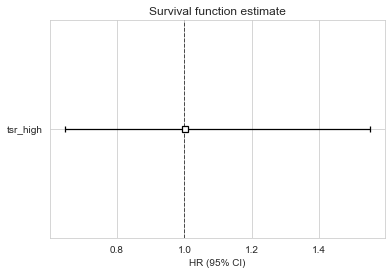

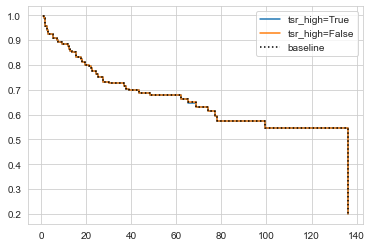

In [62]:
data['tsr_high'] = df.loc[data.index, 'tsr_high'].map({'High': True, 'Low': False})
univar_model = CoxPHFitter().fit(data[['tsr_high', 'os', 'os_event']], duration_col='os', event_col='os_event')
univar_model.plot(hazard_ratios=True)
plt.title('Survival function estimate')
plt.show()

univar_model.plot_partial_effects_on_outcome('tsr_high', values=[True, False])
plt.show()

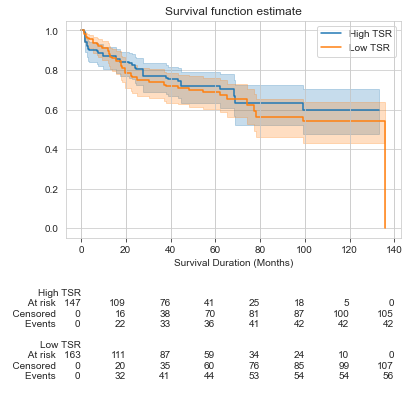

In [63]:
model_high = KaplanMeierFitter().fit(df[df.tsr_high=='High'].os, df[df.tsr_high=='High'].os_event == 'dead')
model_low = KaplanMeierFitter().fit(df[df.tsr_high=='Low'].os, df[df.tsr_high=='Low'].os_event == 'dead')

ax = model_high.plot(label='High TSR')
ax = model_low.plot(ax=ax, label='Low TSR')
plt.title('Survival function estimate')
plt.xlabel('Survival Duration (Months)')
add_at_risk_counts(model_high, model_low, labels=['High TSR', 'Low TSR'], ax=ax)
plt.show()

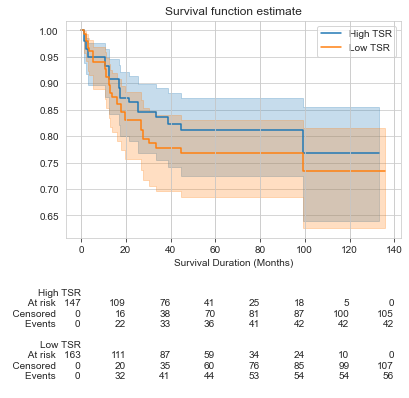

In [64]:
model_free = KaplanMeierFitter().fit(df[df.tsr_high=='High'].dfs, df[df.tsr_high=='High'].dfs_event == 'recurrence')
model_recurrent = KaplanMeierFitter().fit(df[df.tsr_high=='Low'].dfs, df[df.tsr_high=='Low'].dfs_event == 'recurrence')

ax = model_free.plot(label='High TSR')
model_recurrent.plot(ax=ax, label='Low TSR')
plt.title('Survival function estimate')
plt.xlabel('Survival Duration (Months)')
add_at_risk_counts(model_high, model_low, labels=['High TSR', 'Low TSR'], ax=ax)
plt.show()

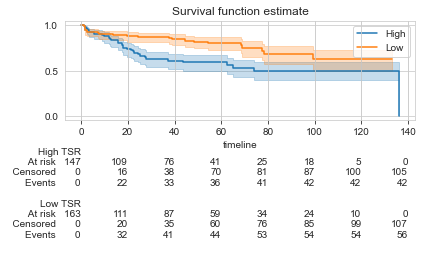

In [65]:
model_free = KaplanMeierFitter().fit(df[~(df.pn_group=='pn0')].os, df[~(df.pn_group=='pn0')].os_event == 'dead')
model_recurrent = KaplanMeierFitter().fit(df[df.pn_group=='pn0'].os, df[df.pn_group=='pn0'].os_event == 'dead')

ax = model_free.plot(label='High')
model_recurrent.plot(ax=ax, label='Low')
plt.title('Survival function estimate')
add_at_risk_counts(model_high, model_low, labels=['High TSR', 'Low TSR'], ax=ax)
plt.tight_layout()
plt.show()

## Acquisition Time/ TSR correlation
During the course of this project, we noticed that calculating for the first 240-ish slides yields TSR values that show a **lower** survival probability. This is contrary to established literature.
When rerunning the statistical tests for a bigger subset of the total dataset that contains later slides, we noticed that trend has reversed.
We try here to investigate the origin of that discrepancy.

In [66]:
full_df = pd.read_pickle('./metadata/bern_data.pkl')
# full_df['patient_id'] = full_df.slide_filename.map(lambda x: x.split('_')[0])
full_df['scan_year'] = full_df.slide_filename.map(lambda x: int(x.split('.')[0].split('_')[1][1:]))

full_df[['slide_filename', 'patient_id', 'scan_year']].head()

,slide_filename,patient_id,scan_year
0,003b_B2010.14359_I-D_HE.mrxs,3,2010
1,003c_B2010.14359_I-E_HE.mrxs,3,2010
4,006b_B2008.17770_I-E_HE.mrxs,6,2008
5,006c_B2008.17770_I-K_HE.mrxs,6,2008
6,006d_B2008.17770_I-G_HE.mrxs,6,2008


In [67]:
# full_df['patient_id'] = LabelEncoder().fit_transform(full_df.patient_id)
full_df[['patient_id', 'scan_year', 'os', 'tsr_est_mean']].dropna().corr()

,patient_id,scan_year,os,tsr_est_mean
patient_id,1.000000,0.829582,-0.399196,-0.141106
scan_year,0.829582,1.000000,-0.534617,-0.124210
os,-0.399196,-0.534617,1.000000,0.113474
tsr_est_mean,-0.141106,-0.124210,0.113474,1.000000


In [68]:
data['patient_id'] = full_df.loc[data.index, 'patient_id']
data['scan_year'] = full_df.loc[data.index, 'scan_year']

data[['patient_id', 'scan_year']].head()

,patient_id,scan_year
0,3,2010
1,3,2010
4,6,2008
5,6,2008
6,6,2008


In [69]:
# data['patient_id'] = LabelEncoder().fit_transform(data.patient_id)
data.corr()

,pm,pn,pt,tnm,tbc,tsr,os,os_event,tsr_high,patient_id,scan_year
pm,1.000000,0.263847,0.326538,0.462190,-0.100662,-0.146628,-0.137003,-0.043116,-0.162170,-0.117577,-0.112490
pn,0.263847,1.000000,0.252242,0.758536,-0.259290,-0.084112,-0.160419,0.279974,-0.093127,-0.002981,-0.075062
pt,0.326538,0.252242,1.000000,0.579775,-0.170099,-0.208180,-0.025341,0.060412,-0.191310,0.044705,-0.000021
tnm,0.462190,0.758536,0.579775,1.000000,-0.237452,-0.147088,-0.099704,0.168294,-0.154219,0.013037,-0.097555
tbc,-0.100662,-0.259290,-0.170099,-0.237452,1.000000,0.220757,0.168648,-0.079159,0.191911,-0.146843,-0.207199
tsr,-0.146628,-0.084112,-0.208180,-0.147088,0.220757,1.000000,-0.063734,-0.086174,0.804215,0.121362,0.171453
os,-0.137003,-0.160419,-0.025341,-0.099704,0.168648,-0.063734,1.000000,-0.391698,-0.066389,-0.153794,-0.418553
os_event,-0.043116,0.279974,0.060412,0.168294,-0.079159,-0.086174,-0.391698,1.000000,-0.031607,-0.098242,-0.132495
tsr_high,-0.162170,-0.093127,-0.191310,-0.154219,0.191911,0.804215,-0.066389,-0.031607,1.000000,0.150769,0.162157
patient_id,-0.117577,-0.002981,0.044705,0.013037,-0.146843,0.121362,-0.153794,-0.098242,0.150769,1.000000,0.638532


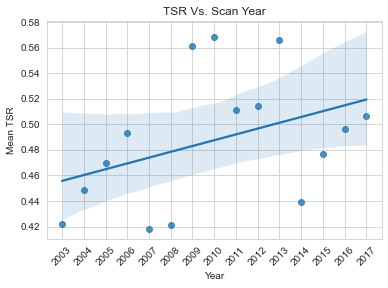

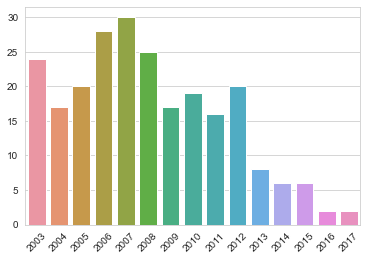

Correlation coefficient: 0.39341182750303855


In [70]:
years = []
mean_tsrs = []
nb_obs = []
for year, group in data.groupby('scan_year'):
    mean_tsrs.append(group.tsr.mean())
    years.append(year)
    nb_obs.append(group.shape[0])
# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_tsrs)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean TSR')
plt.title('TSR Vs. Scan Year')

plt.show()

sns.barplot(x=years, y=nb_obs)
plt.xticks(rotation=45)
plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_tsrs)[0,1]}')

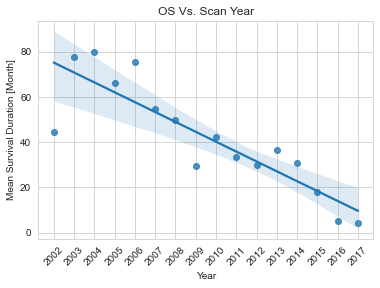

Correlation coefficient: -0.8736636290838559


In [71]:
years = []
mean_oss = []
for year, group in full_df.groupby('scan_year'):
    mean_oss.append(group.os.mean())
    years.append(year)

# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_oss)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean Survival Duration [Month]')
plt.title('OS Vs. Scan Year')

plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_oss)[0,1]}')

Of course! The **observed** survival duration goes lower as the recorded start passes?

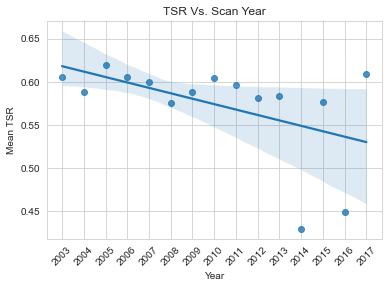

Correlation coefficient: -0.4998852263445826


In [72]:
years = []
mean_tsrs = []
for year, group in full_df.loc[data.index,:].groupby('scan_year'):
    mean_tsrs.append(group.tsr_est_mean.mean())
    years.append(year)

# sns.lineplot(x=years, y=mean_tsrs)
sns.regplot(x=years, y=mean_tsrs)
# plt.plot(years, mean_tsrs)
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Mean TSR')
plt.title('TSR Vs. Scan Year')

plt.show()

print(f'Correlation coefficient: {np.corrcoef(years, mean_tsrs)[0,1]}')